# Import Essential Libraries


In [37]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import  models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
import csv
import pandas as pd

In [2]:
print(torch.cuda.is_available())

True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preparing Dataset

In [4]:
DATA_PATH ="/kaggle/input/cat-dog-images-for-classification/cat_dog"

In [5]:
def show_image(image_path):
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

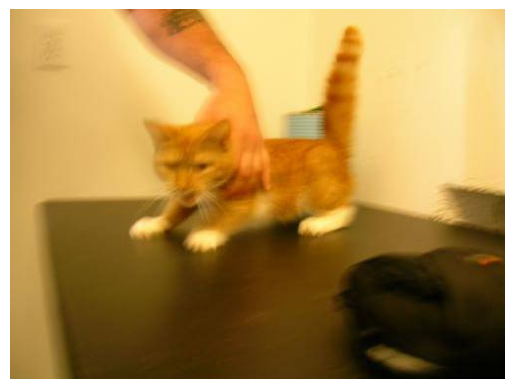

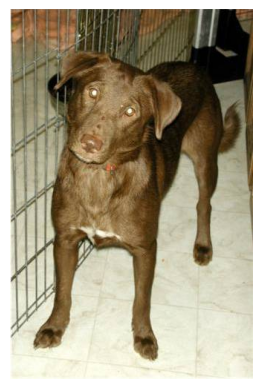

In [6]:
show_image(os.path.join(DATA_PATH, "cat.0.jpg"))
show_image(os.path.join(DATA_PATH, "dog.1.jpg"))

In [7]:
labels_path = "/kaggle/input/cat-dog-images-for-classification/cat_dog.csv"

In [27]:
df = pd.read_csv(labels_path)

print(df)

               image  labels
0      dog.11289.jpg       1
1      cat.10836.jpg       0
2       cat.7970.jpg       0
3       cat.2212.jpg       0
4       dog.2653.jpg       1
...              ...     ...
24995  dog.12201.jpg       1
24996   dog.2893.jpg       1
24997  cat.12267.jpg       0
24998   dog.4380.jpg       1
24999   cat.7962.jpg       0

[25000 rows x 2 columns]


In [29]:
def get_label(image_name):
    try:
        label = df[df['image'] == image_name]['labels'].iloc[0]
        return label
    except IndexError:
        return "Image not found"

In [30]:
image_name = 'cat.11289.jpg'
label = get_label(image_name)
label

0

In [11]:
logger = logging.getLogger(__name__)

class ImageDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Read the CSV file
        df = pd.read_csv(csv_file)
        
        # Collect image paths and labels from CSV
        for _, row in df.iterrows():
            img_name = row['image'].strip()  # Remove any whitespace
            img_path = os.path.join(data_dir, img_name)
            # Verify image exists
            if os.path.isfile(img_path):
                self.images.append(img_path)
                self.labels.append(int(row['labels']))  # Convert label to integer
            else:
                logger.warning(f"Skipping missing image: {img_path}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            img_path = self.images[idx]
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Failed to load image: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            label = self.labels[idx]
            
            # Apply transforms
            if self.transform:
                img = self.transform(img)
            
            return img, label
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {str(e)}")
            # Return None to indicate failure, handled by DataLoader
            return None

In [12]:
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),    
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ImageDataset(DATA_PATH, transform=transforms,csv_file = labels_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
ratio = [0.7, 0.2, 0.1]  # 70% train, 20% val, 10% test
train_size = int(ratio[0] * len(dataset))
val_size = int(ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Training

In [14]:
# Train the model
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        valid_batches = 0  # Track valid batches to compute average loss
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            if batch is None:
                logger.warning("Skipping empty batch")
                continue
            
            images, labels = batch
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            valid_batches += 1
        
        # Compute average loss (handle case where all batches are skipped)
        train_loss = running_loss / max(valid_batches, 1)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        valid_val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    logger.warning("Skipping empty validation batch")
                    continue
                
                images, labels = batch
                # Move data to device
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_val_batches += 1
        
        # Compute validation metrics
        val_loss = val_loss / max(valid_val_batches, 1)
        val_accuracy = 100 * correct / max(total, 1)  # Avoid division by zero
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    return model

## Simple CNN

In [15]:
# Create model

class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = torch.nn.Linear(32 * 56 * 56, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.dropout= torch.nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model_cnn = SimpleCNN(num_classes=len(dataset.labels)).to(device)

In [ ]:
model_cnn = train_model(model_cnn, train_loader, val_loader, num_epochs=10, learning_rate=1e-3)

Using device: cuda


Epoch 1/10: 100%|██████████| 547/547 [02:15<00:00,  4.03it/s]


Epoch [1/10], Loss: 0.7114
Validation Loss: 0.5499, Accuracy: 71.68%


Epoch 2/10: 100%|██████████| 547/547 [02:08<00:00,  4.26it/s]


Epoch [2/10], Loss: 0.5686
Validation Loss: 0.5108, Accuracy: 74.60%


Epoch 3/10: 100%|██████████| 547/547 [02:09<00:00,  4.23it/s]


Epoch [3/10], Loss: 0.5359
Validation Loss: 0.4948, Accuracy: 75.80%


Epoch 4/10: 100%|██████████| 547/547 [02:05<00:00,  4.37it/s]


Epoch [4/10], Loss: 0.4998
Validation Loss: 0.4969, Accuracy: 75.88%


Epoch 5/10: 100%|██████████| 547/547 [02:09<00:00,  4.24it/s]


Epoch [5/10], Loss: 0.4792
Validation Loss: 0.4405, Accuracy: 79.56%


Epoch 6/10: 100%|██████████| 547/547 [02:12<00:00,  4.12it/s]


Epoch [6/10], Loss: 0.4660
Validation Loss: 0.4527, Accuracy: 78.18%


Epoch 7/10: 100%|██████████| 547/547 [02:13<00:00,  4.10it/s]


Epoch [7/10], Loss: 0.4544
Validation Loss: 0.4047, Accuracy: 81.42%


Epoch 8/10:  31%|███▏      | 171/547 [00:41<01:29,  4.20it/s]

In [ ]:
torch.save(model_cnn.state_dict(), "cnn_trained.pth")

## Transfer Learning

In [ ]:
def get_vgg19_model(num_classes=2, freeze_features=True):
    # Load pre-trained VGG19
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
    
    # Freeze feature extraction layers
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False
    
    model.classifier[6] = nn.Linear(4096, num_classes) 
    
    return model

In [ ]:
model_vgg19 = get_vgg19_model(num_classes=2, freeze_features=True)

In [ ]:
model_vgg19 = train_model(model_vgg19, train_loader, val_loader, num_epochs=10, learning_rate=1e-3)

In [ ]:
torch.save(model_vgg19.state_dict(), "vgg19_trained.pth")

# Evaluation

In [32]:
def evaluate_model(model, dataloader, model_name):
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            if images is None:
                continue
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'confusion_matrix': cm
    }

In [38]:
# Evaluate both models
vgg_results = evaluate_model(model_vgg19, test_loader, 'VGG19')
simple_cnn_results = evaluate_model(model_cnn, test_loader, 'SimpleCNN')


In [53]:
def score(model):
    accuracy = model["accuracy"]
    precision = model["precision"]
    f1 = model["f1"]
    cm = model["confusion_matrix"]
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1 Score:", f1)
    #Visualize Confusion Matrix
    class_names = ['Cat', 'Dog']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.8172
Precision: 0.8356047700170358
F1 Score: 0.8110789582472095


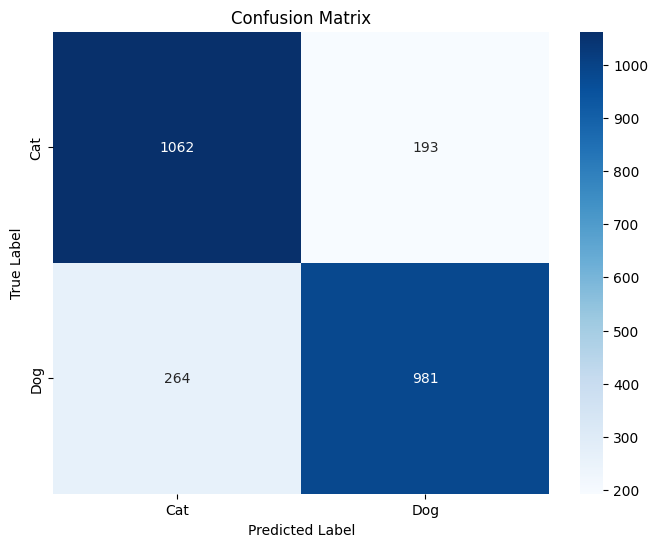

In [58]:
score(simple_cnn_results)

Accuracy: 0.9848
Precision: 0.9801113762927606
F1 Score: 0.9848121502797763


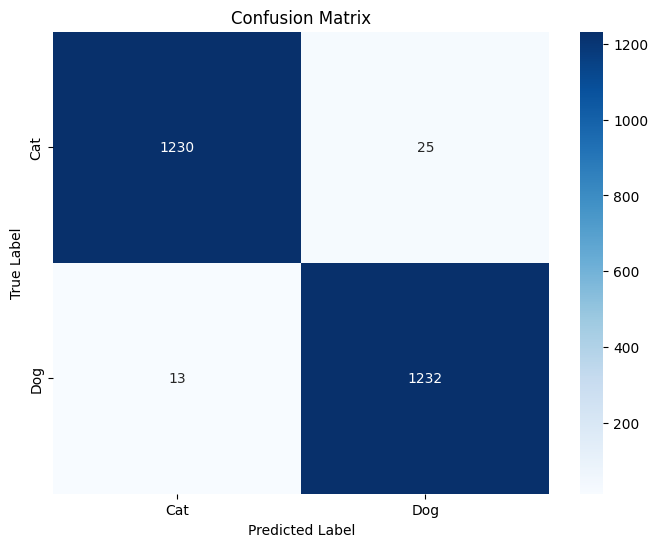

In [60]:
score(vgg_results)